In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
!pip install imutils
!pip install tensorflow

In [4]:
import numpy as np
import pandas as pd
import os
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import imutils
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle #shuffling the data improves the model


RANDOM_SEED = 123

In [5]:
def crop_brain_contour(image, plot=False):

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)                       # in this gaussian blur we apply the standar deviation of X and Y directions
    # Gaussian Noise is a statistical noise having a probability density function equal to normal distribution, also known as Gaussian Distribution.

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    # For every pixel, the same threshold value is applied. If the pixel value is smaller than the threshold, it is set to 0, otherwise it is set to a maximum value.
    #The function cv.threshold is used to apply the thresholding.
    #The first argument is the source image, which should be a grayscale image.
    #The second argument is the threshold value which is used to classify the pixel values.
    #The third argument is the maximum value which is assigned to pixel values exceeding the threshold.

    thresh = cv2.erode(thresh, None, iterations=2)
    #cv2.erode() method is used to perform erosion on the image.
    #The basic idea of erosion is just like soil erosion only, it erodes away the boundaries of foreground object.
    #It is normally performed on binary images. It needs two inputs, one is our original image, second one is called structuring element or kernel which decides the nature of operation. A pixel in the original image (either 1 or 0) will be considered 1 only if all the pixels under the kernel is 1, otherwise it is eroded (made to zero).
    thresh = cv2.dilate(thresh, None, iterations=2)
    #This operation is the sister of dilation. It computes a local minimum over the area of given kernel.



    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    cv2.drawContours(image, cnts, -1, (0, 0, 255), 2)

    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
        cv2_imshow(image)

    return new_image


In [6]:
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    i=0
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            # only for plotting single preprocessed brain image image
            if (i==0):
              image = crop_brain_contour(image, plot=True)
              i=i+1
            else:
              image = crop_brain_contour(image, plot=False)

            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            #If you are enlarging the image, you should prefer to use INTER_LINEAR or INTER_CUBIC interpolation.
            #For shrinking the image, INTER_AREA interpolation.
            #Cubic interpolation is computationally more complex, and hence slower than linear interpolation.
            #However, the quality of the resulting image will be higher.

            # normalize values
            image = image / 255.

            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

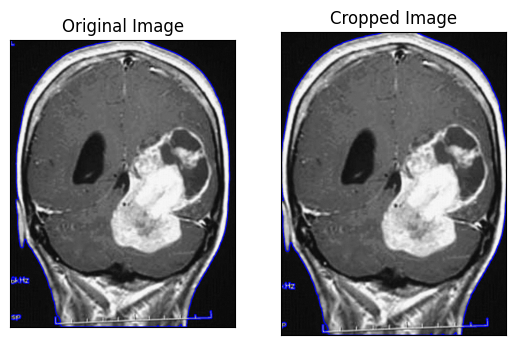

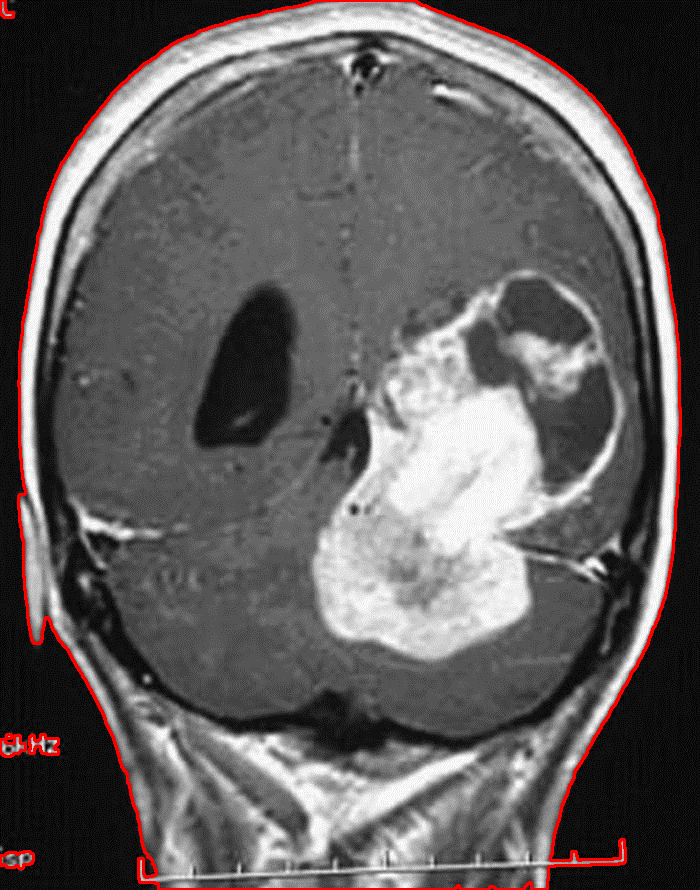

Number of examples is: 253
X shape is: (253, 240, 240, 3)
y shape is: (253, 1)


In [7]:
augmented_data_path = '/content/drive/MyDrive/data/'
augmented_yes = augmented_data_path + 'yes'
augmented_no = augmented_data_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

In [8]:
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))

        i = 1 # current plot
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            # remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

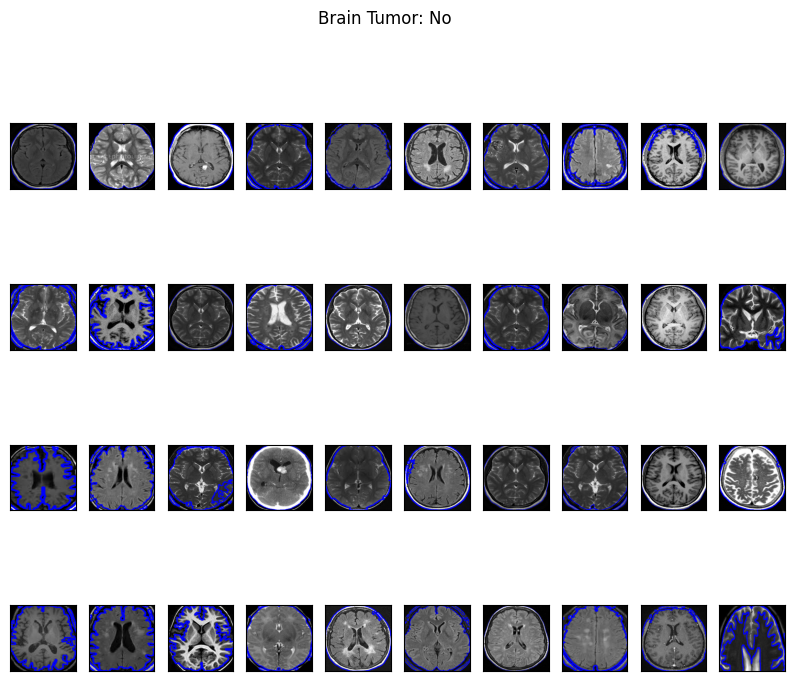

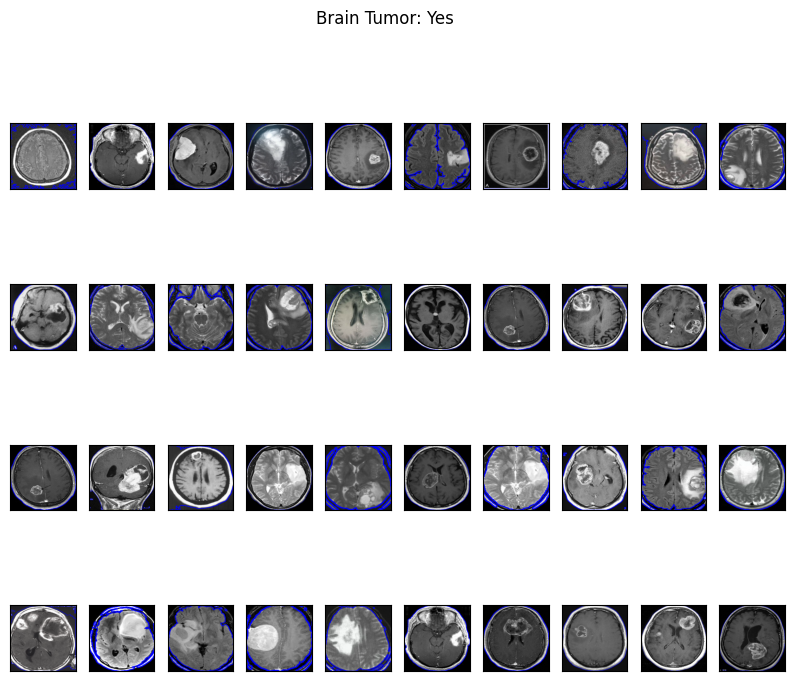

In [9]:
plot_sample_images(X, y)

In [10]:
def split_data(X, y, test_size=0.2):

    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.8)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [11]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.2)

In [12]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 202
number of validation examples = 41
number of test examples = 10


In [13]:
def build_model(input_shape):
    X_input = Input(input_shape)
    X = ZeroPadding2D((2, 2))(X_input)

    X = Conv2D(32, (7, 7), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((4, 4))(X)
    X = MaxPooling2D((4, 4))(X)

    X = Flatten()(X)
    X = Dense(1, activation='sigmoid')(X)

    model = Model(inputs = X_input, outputs = X)

    return model

In [14]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model=build_model(IMG_SHAPE)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 244, 244, 3)       0         
 g2D)                                                            
                                                                 
 conv2d (Conv2D)             (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 59, 32)        0         
 D)                                                          

In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=22, validation_data=(X_val, y_val))
model.save("Brain_tumor_detection.h5")

Epoch 1/22
7/7 [==============================] - 34s 5s/step - loss: 1.6564 - accuracy: 0.4950 - val_loss: 0.6354 - val_accuracy: 0.6585
Epoch 2/22
7/7 [==============================] - 24s 3s/step - loss: 0.7167 - accuracy: 0.6733 - val_loss: 0.6297 - val_accuracy: 0.6829
Epoch 3/22
7/7 [==============================] - 24s 3s/step - loss: 0.5708 - accuracy: 0.7574 - val_loss: 0.6096 - val_accuracy: 0.6585
Epoch 4/22
7/7 [==============================] - 22s 3s/step - loss: 0.4579 - accuracy: 0.7921 - val_loss: 0.6026 - val_accuracy: 0.6585
Epoch 5/22
7/7 [==============================] - 24s 3s/step - loss: 0.4033 - accuracy: 0.8218 - val_loss: 0.6014 - val_accuracy: 0.7317
Epoch 6/22
7/7 [==============================] - 22s 3s/step - loss: 0.3805 - accuracy: 0.8267 - val_loss: 0.6234 - val_accuracy: 0.7073
Epoch 7/22
7/7 [==============================] - 25s 3s/step - loss: 0.3563 - accuracy: 0.8267 - val_loss: 0.5743 - val_accuracy: 0.7073
Epoch 8/22
7/7 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
history = model.history.history

In [17]:
def plot_metrics(history):

    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

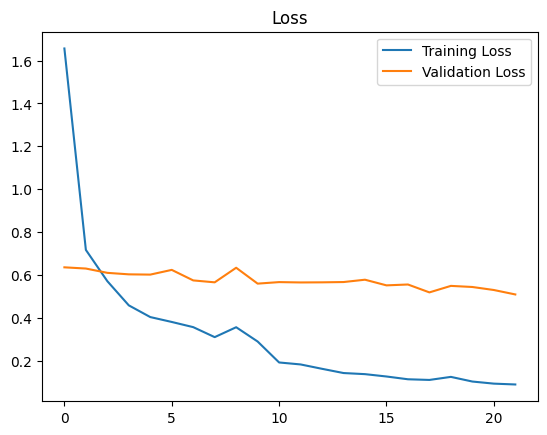

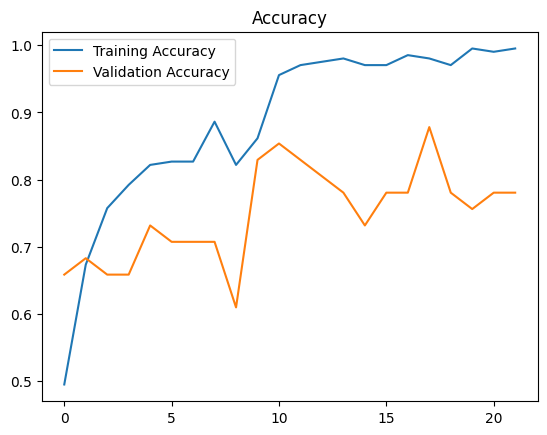

In [18]:
plot_metrics(history)

In [19]:
from sklearn.metrics import accuracy_score

predictions = model.predict(X_val)
predictions_binary = [1 if x > 0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions_binary)
print('Val Accuracy = %.2f' % accuracy)


2/2 [==============================] - 2s 467ms/step
Val Accuracy = 0.78


In [20]:
# validate on test set
predictions = model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]
accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

1/1 [==============================] - 0s 302ms/step
Test Accuracy = 0.80


In [21]:
from keras.models import load_model
tumor_model = load_model('/content/Brain_tumor_detection.h5')
#acc = tumor_model.evaluate(X_test,y_test)


In [35]:
from google.colab import files

# Upload Image5.jpg to the current directory in Colab
uploaded = files.upload()



Saving Y8.jpg to Y8.jpg


In [36]:


# Example: Reading an image file
image_path = 'Y8.jpg'

# Attempt to read the image
test_img = cv2.imread(image_path)

if test_img is None:
    print(f"Error: Image file '{image_path}' not found or could not be read.")
else:
    # Resize and expand dimensions (example)
    test_img = cv2.resize(test_img, (240, 240))
    test_img = np.expand_dims(test_img, axis=0)
    print("Shape after resizing and expanding dimensions:", test_img.shape)




Shape after resizing and expanding dimensions: (1, 240, 240, 3)


In [37]:
test_pred = tumor_model.predict(test_img)
test_pred

1/1 [==============================] - 0s 46ms/step


array([[1.]], dtype=float32)

In [38]:
if (test_pred[0,0]==1):
  print("Tumor Found")
else:
  print("Tumor Not Found")

Tumor Found


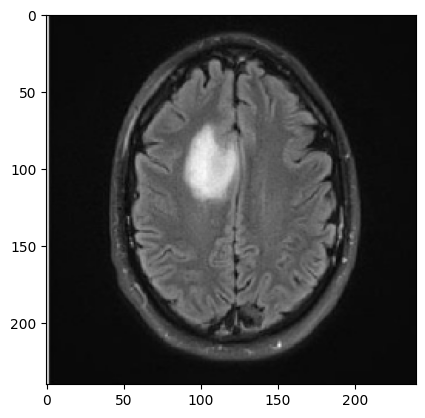

In [39]:
image = np.squeeze(test_img)
plt.imshow(image)

In [40]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits

# Load sample dataset (digits) for illustration
digits = load_digits()
X = digits.images
y = digits.target

# Flatten each image into a 1D array
X_flat = X.reshape((X.shape[0], -1))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Verify the shape after flattening
print("Shape after flattening:", X_train.shape)

# Initialize the classifier
classifier = LogisticRegression(max_iter=10000)

# Fit the classifier on the flattened data
classifier.fit(X_train, y_train)

# Evaluate the classifier
accuracy = classifier.score(X_test, y_test)
print(f"Accuracy: {accuracy}")


Shape after flattening: (1437, 64)
Accuracy: 0.9722222222222222


In [41]:
X_train.shape

(1437, 64)

In [42]:
# Assuming X_test is already flattened
nsamples, nfeatures = X_test.shape
print(f"Number of samples: {nsamples}, Number of features: {nfeatures}")


Number of samples: 360, Number of features: 64


In [43]:
y_pred = classifier.predict(X_test.reshape((nsamples,-1)))

In [44]:
# Making confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
cm

array([[33,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 28,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 33,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 33,  0,  1,  0,  0,  0,  0],
       [ 0,  1,  0,  0, 45,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0, 44,  1,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  1, 34,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0, 33,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0, 29,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  1, 38]])

In [45]:
from sklearn import metrics
prediction = metrics.accuracy_score(y_test,y_pred)
print("Accuracy : " , prediction * 100 , "%")

Accuracy :  97.22222222222221 %


In [ ]:
!pip install streamlit -q

In [ ]:
!wget -q -O - ipv4.icanhazip.com

In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import cv2
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image

# Load the trained model
model = load_model("/content/Brain_tumor_detection.h5")

# Function to preprocess and predict
def predict_tumor(image):
    image = np.array(image)
    image = cv2.resize(image, (240, 240))
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)
    return prediction[0,0]

# Streamlit App
st.title("Brain Tumor Detection")

uploaded_file = st.file_uploader("Choose an image...", type="jpg")

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image.', use_column_width=True)
    st.write("")
    st.write("Classifying...")
    prediction = predict_tumor(image)

    if prediction > 0.5:
        st.write("Tumor Found")
    else:
        st.write("No Tumor Found")


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501